# ID control selection
This notebook selects fitting ID controls to patients with a specific syndrome. 

In [1]:
import pandas as pd
import os
import os.path
from os import listdir
from os.path import isfile, join
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import openpyxl

In [2]:
syn_name = "YY1"

In [3]:
# open KdV excel sheet
#kdv_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-patients\DatabasePatients_edit_nov_2017.xlsx"
syn_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}_Database.xlsx".format(syn_name, syn_name)

assert os.path.exists(syn_file), "This path doesn't exist."

df_syn = pd.read_excel(syn_file)
df_syn = df_syn[['Patient', 'Age on photo', 'Gender']]
df_syn.rename(columns={'Patient':'image','Age on photo':'age', 'Gender':'gender'},inplace=True)

index_with_nan = df_syn.index[df_syn.isnull().any(axis=1)]
df_syn.drop(index_with_nan,0, inplace=True)
#df_syn

### check whether that image is actually present
syn_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-all-photos".format(syn_name, syn_name)
drop_indices = []

for index, row in df_syn.iterrows():
    image = row['image']
    files = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f)) and image.replace("ANKRD","ANKRD11" ) + ".jpg" in f)]
    if(len(files)==0):
        drop_indices.append(index)

df_syn = df_syn.drop(drop_indices)
df_syn

,image,age,gender
0,YY1_1,2.0,M
1,YY1_2,15.0,M
2,YY1_3,5.0,F
3,YY1_4,39.0,F
4,YY1_5,17.0,F
5,YY1_6,7.0,M
6,YY1_7,1.0,M
7,YY1_8,25.0,F
8,YY1_9,9.0,M
9,YY1_10,1.0,F


12


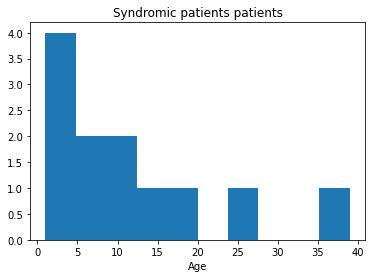

In [4]:
# Make a histogram of all ages

ages_syn = df_syn.age.values
print(len(ages_syn))
plt.hist(ages_syn)
plt.xlabel("Age")
plt.title("Syndromic patients patients")
plt.show()

In [5]:
# open ID control excel sheet
ID_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ID-controls\all_ID_controls_info_complete.xlsm" 
assert os.path.exists(ID_file), "This path doesn't exist."

df_ID = pd.read_excel(ID_file)
df_ID = df_ID[['pnummer', 'frontal face image', 'agecorrected', 'gender']]
df_ID = df_ID[df_ID['frontal face image'].notnull()]
df_ID = df_ID.rename(columns={"frontal face image": "image", "agecorrected": "age"})

print(df_ID.shape)
df_ID.sample(2)

(381, 4)


,pnummer,image,age,gender
94,P05-0824,DSCN7362.JPG,9,f
310,P09-2299,P09-2299_F1_.JPG,12,f


In [6]:
# for each entry in KdV df find a matching ID control, save in new pandas dataframe

# empty object
df_select_syn = pd.DataFrame(columns=['image', 'age', 'gender'])
df_select_ID = pd.DataFrame(columns=['pnummer', 'image', 'age', 'gender'])

age_dif_list = []
low_age = 0
high_age = 100 # aka all patients, can be adjusted in case of age groups

# find control ID for each syndromic patients
for index, row in df_syn.iterrows():

    age_syn = int(row['age'])
    
    if  low_age <= age_syn <= high_age:
        
        gender_syn = row['gender'].lower()
    
        # find a control ID with exact same age
        matches_ID = df_ID.loc[(df_ID['age'] == age_syn) & (df_ID['gender'] == gender_syn)]
        
        # try different age differences
        age_dif = [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6]
        i = 0   
        while matches_ID.shape[0] == 0:
            matches_ID = df_ID.loc[(df_ID['age'] == age_syn + age_dif[i]) & (df_ID['gender'] == gender_syn)]
            i+= 1
            if i == len(age_dif):
                break

        if(matches_ID.shape[0] ==0):
            print("For patient {}, gender: {}, age: {}".format(row['image'], row['gender'], row['age']))
            print("No match found within {} and {} years".format(max(age_dif), min(age_dif)))
            continue

        #age_dif_list.append(age_dif[i])
        
        # a match is found, so append sy patient
        df_select_syn = df_select_syn.append(row) 

        # pick a random control from this list to append to selected controls
        random_index = random.randint(0, matches_ID.shape[0]-1)
        select_ID = matches_ID.iloc[random_index]
        df_select_ID = df_select_ID.append(select_ID)

        # remove selected row from set of all controls 
        i = df_ID[(df_ID.image == select_ID.image) & (df_ID.pnummer == select_ID.pnummer)].index

        OG_shape = df_ID.shape
        df_ID = df_ID.drop(i)
        new_shape = df_ID.shape  
        

        if(OG_shape[0] - new_shape[0]> 1):
            print("Error")
            
print("Done finding all ID controls.")

Done finding all ID controls.


In [7]:
print(df_select_syn.shape)
print(df_select_ID.shape)

(12, 3)
(12, 4)


In [8]:
# save information to 2 Excel files
syn_info_save = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}_patients_info.xlsx".format(syn_name, syn_name)
ID_info_save = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}_matched_ID_controls_info.xlsx".format(syn_name, syn_name)
df_select_syn.to_excel(syn_info_save)
df_select_ID.to_excel(ID_info_save)


### Open Excel files and write the found images to a new directory

In [9]:
ID_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ID-controls"
select_ID_dir =  r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-selected-ID-controls".format(syn_name, syn_name)

# open excel file
df_ID = pd.read_excel(ID_info_save)

for index,rows in df_ID.iterrows():
    pnr = rows['pnummer']
    image = rows['image']
    
    files = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ((pnr + "_small_" + image.replace(".JPG", "")) in f))]
    if(len(files)==1):
        im = Image.open(join(ID_dir, files[0]))
        im.save(join(select_ID_dir, files[0]))
    else: 
        print("Manually find image for " + str(pnr) + "_small_" + str(image.replace(".JPG", "")))   
        print("in " + str(ID_dir))
        
print("Done saving ID files.")

Done saving ID files.


In [10]:
syn_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-all-photos".format(syn_name, syn_name)
select_syn_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-patients".format(syn_name, syn_name)

df_syn = pd.read_excel(syn_info_save)

for index,rows in df_syn.iterrows():
    image = rows['image']
    files = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f)) and image.replace("ANKRD","ANKRD11" ) + ".jpg" in f)]
    if(len(files)==1):
        im = Image.open(join(syn_dir, files[0]))
        im.save(join(select_syn_dir, files[0]))
    else: 
        print("Manually find image for image: {}".format(image))
        
print("Done saving syndrome files.")

Done saving syndrome files.
